# Team Name - Blitzkreig
## Indian Institute of Technology Kharagpur
### Arusarka Bose, Naman Paharia, Gauranshi Chauhan

- >Github Repo: https://github.com/Gauranshi/AbInBev-Maverick-2.0/tree/main
- >Website: https://share.streamlit.io/arusarkabose/discount-predicter/main/app.py

Pipeline:
<img src = 'https://drive.google.com/uc?id=1jXansDiG4LQ2S4mNilg843ImXxpJvXjQ' >

## Importing Library and Data

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import check_array
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import XGBClassifier
#from lazypredict.Supervised import LazyRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
#import autosklearn.classification
#import lightgbm as lgb
import pickle
import urllib
import seaborn as sns

In [6]:
!pip install pandas --upgrade

In [9]:
import gdown
url = 'https://drive.google.com/uc?id=13celyxcevwAaKGcNXjJhHZAHMp0Yl_u8'
output = 'data.xlsx'
gdown.download(url, output, quiet=False)
path  ='data.xlsx'
data = pd.read_excel(path, sheet_name = 'Data',engine='openpyxl')
df = data.copy()

Downloading...
From: https://drive.google.com/uc?id=13celyxcevwAaKGcNXjJhHZAHMp0Yl_u8
To: C:\Users\Arusarka\Downloads\data.xlsx
4.11MB [00:00, 4.75MB/s]


## Pre-processing 

> - Replace missing data with the mode of Attribute
> - Numerical values are replaced with 0 if less than a threshold (0.0005), to prevent Numerical Overflow
> - Drop non-significant attributes (Ship-to ID, Product Set, Discount_Total)

In [12]:
def basic_preprocessing(df):
    for i in range(len(df)):
        if (abs(df.loc[i,'Volume_2019 Product'])<0.0005):
            df.loc[i,'Volume_2019 Product']=0
        if (abs(df.loc[i,'OffInvoice Discount(LCU)'])<0.0005):
            df.loc[i,'OffInvoice Discount(LCU)']=0
        if (abs(df.loc[i,'OnInvoice Discount(LCU)'])<0.0005):
            df.loc[i,'OnInvoice Discount(LCU)']=0

        if (df.loc[i,'poc_image']==0):
            df.loc[i,'poc_image']='Mainstream'

    df.loc[9,'segment']='Institutional'                            # REPLACED A SINGLE MISSING VALUE
    drop_cols=['Ship-to ID','Product Set','Discount_Total']
    df=df.drop(drop_cols,axis=1)
    df=df.iloc[0:-4]                                               # REPLACED A SINGLE MISSING VALUE
    return df
df = basic_preprocessing(df)

### Outlier removal
> - Remove data points with Z-score above a threshold. Formula for Z-score is given as:

$$ 
\text{Z-Score} = \frac{X-\text{Mean}}{\text{Standard Deviation}}
$$

Threshold is chosen as 3 as it indicates a spread of 3 Standard Deviation which covers 99.7% of the gaussian distribution.

> - Remove data points with Negative values of discount, volume or GTO

In [13]:
def outlier_removal(df):
    cols = ['Volume_2019', 'GTO_2019', 'OnInvoice Discount(LCU)', 'OffInvoice Discount(LCU)', 'Tax']
    mask=np.ones(len(df),dtype=bool)               # CREATING A MASK TO STORE ROWS
    threshold=3
    for col in cols:
        z_score=(df[col]-df[col].mean())/df[col].std(ddof=0)
        for i,j in enumerate(df[col]):
            if (j<0):
                mask[i]=0
        for i,j in enumerate(z_score):
            if (j>threshold):
                mask[i]=0
    df = df[mask] 
    df=df.reset_index().drop(['index'],axis=1)
    return df
df = outlier_removal(df)

## Exploratory Data Analysis

* Correlation heatmap for the numeric columns illustrates that the OnInvoice Discount is more correlated with the GTO_2019 as compared to the OffInvoice Discount. Though through line plots it seems that the opposite is true, the high number of zero values in the OffInvoice Discount column reduces its correlation.

<AxesSubplot:>

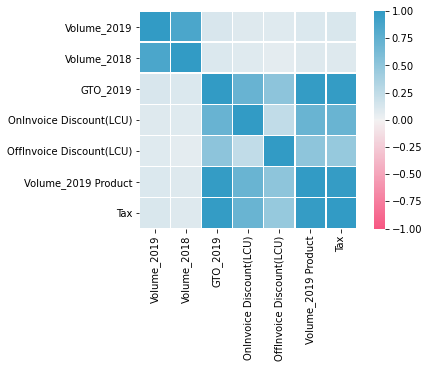

In [14]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(df.corr(), cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5)


* Through violinplots of the sales volumes for the financial years 2018 and 2019, we infer that the mean volume sold in 2018 is slightly higher than that in 2019.

<AxesSubplot:>

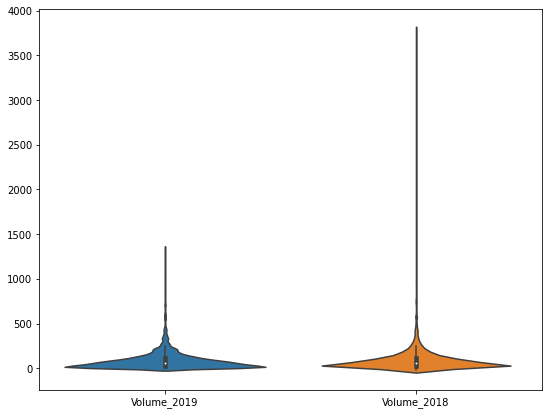

In [15]:
fig, ax = plt.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, data = df.iloc[:, 0:2])

* Through regression model plots of the turnover against the OffInvoice and OnInvoice discounts, we see that outliers are more prominent in the OffInvoice column as is visible by the relatively low slope of the mean regression line.

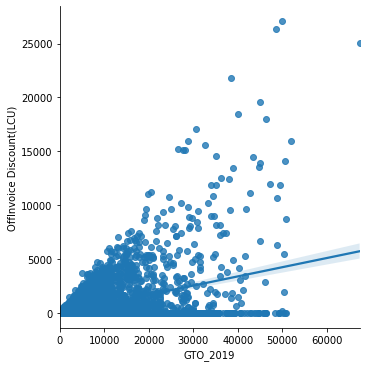

In [16]:
sns.lmplot(x='GTO_2019', y='OffInvoice Discount(LCU)', data=df)

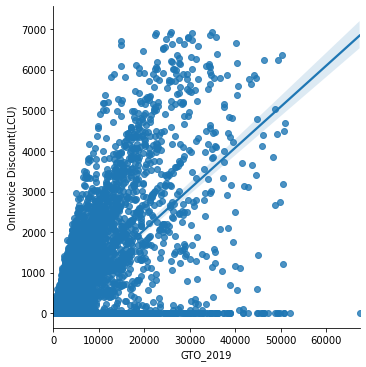

In [17]:
sns.lmplot(x='GTO_2019', y='OnInvoice Discount(LCU)', data=df)

* The percentage of zeros in the OffInvoice column is much higher than that in the OnInvoice column as is exposed by the histogram plots.

<AxesSubplot:xlabel='OnInvoice Discount(LCU)', ylabel='Count'>

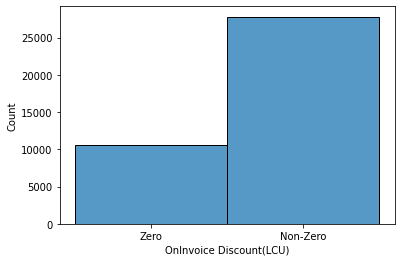

In [18]:
eda_df=df.copy()
for i in range(len(eda_df)):
    if(eda_df.loc[i,"OnInvoice Discount(LCU)"]):
        eda_df.loc[i,"OnInvoice Discount(LCU)"]="Non-Zero"
    else:
        eda_df.loc[i,"OnInvoice Discount(LCU)"]="Zero"
sns.histplot(data=eda_df, x="OnInvoice Discount(LCU)", kde=False)

<AxesSubplot:xlabel='OffInvoice Discount(LCU)', ylabel='Count'>

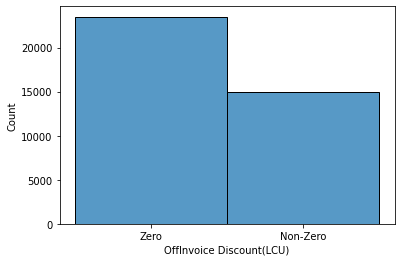

In [19]:
eda_df=df.copy()
for i in range(len(eda_df)):
    if(eda_df.loc[i,"OffInvoice Discount(LCU)"]):
        eda_df.loc[i,"OffInvoice Discount(LCU)"]="Non-Zero"
    else:
        eda_df.loc[i,"OffInvoice Discount(LCU)"]="Zero"
sns.histplot(data=eda_df, x="OffInvoice Discount(LCU)", kde=False)

* We observe that around 85% of the OffInvoice Discount values are within 34.65% of the respective GTO_2019 values

Text(0, 0.5, 'Value')

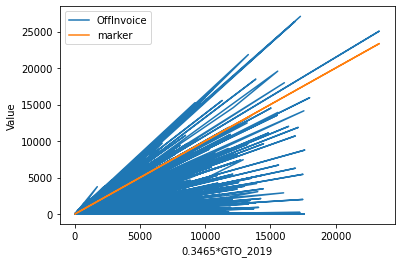

In [20]:
eda_df=df.copy()
eda_df['marker']=0
for i in range(len(eda_df)):
    eda_df.loc[:,'marker']=0.3465*eda_df.loc[:,'GTO_2019']
plt.plot(eda_df.marker,eda_df['OffInvoice Discount(LCU)'],label='OffInvoice')
plt.plot(eda_df.marker,eda_df['marker'],label='marker')
plt.legend()
plt.xlabel('0.3465*GTO_2019')
plt.ylabel('Value')

* We calculate the Cramer's V correlation matrix for the categorical columns of the dataset

In [21]:
data=df[['sfdc_tier','poc_image','segment','sub_segment','Brand','Sub-Brand','Pack_Type','Returnalility','province']]
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in data.columns :
    data_encoded[i]=label.fit_transform(data[i])

In [22]:
from scipy.stats import chi2_contingency
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [23]:
rows= []

for var1 in data_encoded:
    col = []
    for var2 in data_encoded :
        cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
  
cramers_results = np.array(rows)
eda_df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

Apart from the obvious correlations between Brand and Sub-Brand, and Segment and Sub-Segment, we observe that there is high correlation between the Pack_Type and Returnability columns. 

All of the CAN and BULK are OW, along with 7.74% of the BOTTLE category, while all of the data points in the rest of the Pack_Type categories are RETURNABLE.


<AxesSubplot:>

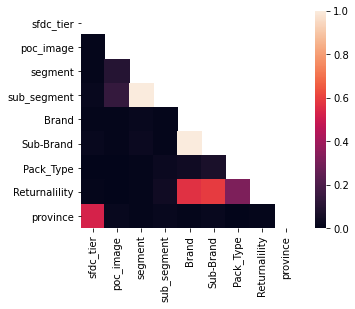

In [24]:
mask = np.zeros_like(eda_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(eda_df, mask=mask, vmin=0., vmax=1, square=True)

## Feature Engineering
1. **Volume Difference**: Discount multiplier based on the sales volume difference between the financial years 2019 and 2018. 

> - For reduced volumes, a multiplier factor of 1.24 is provided to incentivise higher sales.
> - For stagnant volumes, a multiplier factor of 1.12 is provided to incentivise higher sales.
> - For increased volumes, the multiplier factor is 0.95 in order to increase the sales profits.

2. **Tiering Structure**: Modified tiering structure clubbing the lower tier premiums with the higher tier mainstreams, in accordance with similarity trends between the same:

<center> Tier 2 Mainstream &xrarr; Tier 3  </center>
<center> Tier 1 Mainstream + Tier 2 Premium &xrarr; Tier 2 </center>
<center> Tier 0 Mainstream + Tier 1 Premium &xrarr; Tier 1 </center>
<center> Tier 0 Premium &xrarr; Tier 0  </center>

3. **Discount Multiplier**: Discount multipier factor based on the average sales volume. The multiplier has been defined through the creation of a slab system which would encourage the PoS to increase the order volumes to move higher up the discount slabs:

| Volume Slab | Discount Multiplier |
| ----------- | ----------- |
| > 60 percentile and < 70 percentile | 1.1 |
| > 70 percentile and < 80 percentile | 1.15 |
| > 80 percentile and < 90 percentile | 1.2 |
| > 90 percentile and < 95 percentile | 1.3 |
| > 95 percentile and < 99 percentile | 1.35 |
| > 99 percentile and < 99.9 percentile | 1.4 |
| > 99.9 percentile | 1.5 |
<br>

4. **Sales Share**: For each POC, it is the ratio of volume sold by that POC to total volume of liquor sold in that province. Formula for sales share can be given as: 
$$\frac{Volume_{ POC}}{\sum_{}Volume_{POC\in Province^{i}}} $$


5. **Product Cost**: It is the price of a particular product being sold at POC. Assuming tax rate to be r, total transaction value will be Tax/r, thus procuct price can be given as:
$$ \frac{Tax}{r \times Volume}$$

In [25]:
def volume_discmult(df):
    df['vol_diff']=df['Volume_2019']-df['Volume_2018']
    df['vol_disc']=df['Discount_Total']
    df.loc[df['vol_diff']<0, 'vol_disc'] *=1.24
    df.loc[df['vol_diff']==0, 'vol_disc'] *=1.12
    df.loc[df['vol_diff']>0, 'vol_disc'] *=0.95
    return df

In [26]:
def tiering_struct(df):
    df['new_tier']=''
    for i in range(len(df)):
        tier=df.loc[i,'sfdc_tier']
        poc=df.loc[i,'poc_image']
        if (tier=='Tier 2' and poc=='Mainstream'):
            df.loc[i,'new_tier']='Tier 3'
        elif ((tier=='Tier 1' and poc=='Mainstream') or (tier=='Tier 2' and poc=='Premium')):
            df.loc[i,'new_tier']='Tier 2'
        elif ((tier=='Tier 0' and poc=='Mainstream') or (tier=='Tier 1' and poc=='Premium')):
            df.loc[i,'new_tier']='Tier 1'
        elif (tier=='Tier 0' and poc=='Premium'):
            df.loc[i,'new_tier']='Tier 0'
    df=df.drop(['poc_image','sfdc_tier'],axis=1)
    return df

In [27]:
def engineer_discmult(df):
    df["avg_annual_vol"]=(df['Volume_2019']+df['Volume_2018'])/2
    df["discount_multiplier"]=0
    qn=dict()
    qn["60"]=df.avg_annual_vol.quantile(0.6)
    qn["70"]=df.avg_annual_vol.quantile(0.7)
    qn["80"]=df.avg_annual_vol.quantile(0.8)
    qn["90"]=df.avg_annual_vol.quantile(0.9)
    qn["95"]=df.avg_annual_vol.quantile(0.95)
    qn["97"]=df.avg_annual_vol.quantile(0.97)
    qn["99.9"]=df.avg_annual_vol.quantile(0.999)
    for i in range(len(df)):
        vol=df.loc[i,"avg_annual_vol"]
        if  (vol>=qn["60"] and vol<qn["70"]):
            df.loc[i,"discount_multiplier"]=1.1
        elif (vol>=qn["70"] and vol<qn["80"]):
            df.loc[i,"discount_multiplier"]=1.15
        elif (vol>=qn["80"] and vol<qn["90"]):
            df.loc[i,"discount_multiplier"]=1.2
        elif (vol>=qn["90"] and vol<qn["95"]):
            df.loc[i,"discount_multiplier"]=1.3
        elif (vol>=qn["95"] and vol<qn["99"]):
            df.loc[i,"discount_multiplier"]=1.35
        elif (vol>=qn["99"] and vol<qn["99.9"]):
            df.loc[i,"discount_multiplier"]=1.4
        elif (vol>=qn["99.9"]):
            df.loc[i,"discount_multiplier"]=1.5
    return df

In [28]:
def sales_share(df):
    prov_dic = {}
    for i in range(len(df)):
        if(df.loc[i,'province'] in prov_dic):
            prov_dic[df.loc[i,'province']] += df.loc[i,'Volume_2019 Product']
        else:
            prov_dic[df.loc[i,'province']] = df.loc[i,'Volume_2019 Product']
    df['sales_share']=df['Volume_2019 Product']
    for i in range(len(df)):
        df.loc[i,'sales_share'] = df.loc[i,'Volume_2019'] / prov_dic[df.loc[i,'province']]
    return df

In [29]:
def product_cost(df):
    df['product_cost']=df['Tax']
    prod = {}
    dx = df
    for i in range(len(df)):
        tax=df.loc[i,'Tax']
        vol=df.loc[i,'Volume_2019 Product']
        if( vol!=0):
            prod[backup.loc[i,'Product Set']] = tax/vol
            df.loc[i,'product_cost']= tax/vol
        if(vol==0):
            if backup.loc[i,'Product Set'] in prod:
                df.loc[i,'product_cost']= prod[backup.loc[i,'Product Set']]
            else:
                df.loc[i,'product_cost'] = int(25)
    return df

## One-Hot Encoding and Label Encoding
> -   One-hot encode Nominal categorical columns using Pandas
> -   Label encode Ordinal categorical columns using Sk-learn



In [30]:
#ONE-HOT ENCODING AND LABEL ENCODING
def encoding(df):
    oh_cols=['poc_image','segment','Brand','sub_segment','Pack_Type','Returnalility','province','Sub-Brand']
    #oh_cols=['segment','Brand','sub_segment','Pack_Type','Returnalility']
    df=pd.get_dummies(data = df,columns=oh_cols)
    le = preprocessing.LabelEncoder()
    le.fit(df.sfdc_tier)
    df.sfdc_tier=le.transform(df.sfdc_tier)
    return df
df = encoding(df)

## Split between training and test datasets


> -   Drop both Discounts values from Train
> -   Split between Train and Test datasets taking the split ratio as a user-defined parameter



In [31]:
def df_train_test_split(df, target_var):
    if(target_var =='on'):
        target='OnInvoice Discount(LCU)'
        other = 'OffInvoice Discount(LCU)'
    if(target_var =='off'):
        target='OffInvoice Discount(LCU)'
        other = 'OnInvoice Discount(LCU)'
    df=df.drop([other],axis=1)
    Y=df.loc[:,target]
    X=df.drop([target],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

## Model Architecture

### OnInvoice Discount

LOAD PRETRAINED MODELS

This cell can be skipped and runing the subsequent cells would initialize and train the models, or load these pretrained models and comment the necessary lines in the concerned blocks.

In [32]:
#LOAD TRAINED MODELS FROM ULRS

url = "https://www.dropbox.com/s/ml4a9jilm2vcnuj/on_xgbreg.pickle.dat?dl=1"  # dl=1 is important
urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open('on_reg.pickle.dat', "wb") as f :
    f.write(data)

regressor=pickle.load(open("on_reg.pickle.dat", "rb"))

url = "https://www.dropbox.com/s/0aplcor3qhin2j1/on_clf1.pickle.dat?dl=1"  # dl=1 is important
urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open('on_clf1.pickle.dat', "wb") as f :
    f.write(data)

clf=pickle.load(open("on_clf1.pickle.dat", "rb"))

url = "https://www.dropbox.com/s/4amnhgx27b7jzgf/on_clf2.pickle.dat?dl=1"  # dl=1 is important
urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open('on_clf2.pickle.dat', "wb") as f :
    f.write(data)
clf2=pickle.load(open("on_clf2.pickle.dat", "rb"))

url = "https://www.dropbox.com/s/e46p2nc2s6xbgiz/rfreg_on.pickle.dat?dl=1"  # dl=1 is important
urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open('on_rfr.pickle.dat', "wb") as f :
    f.write(data)
rfr=pickle.load(open("on_rfr.pickle.dat", "rb"))

[20:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\arusarka\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\arusarka\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\arusarka\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\arusarka\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: Use

Training Classifier

Two classifier are trained:
- > Decision Tree Classifier: Creates a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 
- > XGBoost Classifer: Boosting is based on weak learners and it reduces the bias error thus is useful to explain variance of the dataset.

Decision Tree has high bias, low variance whereas XGBoost has low bias, high variance, thus ensemble of these two models produces the best results

In [33]:
X_train, X_test, y_train, y_test = df_train_test_split(df,'on')

# CLASSIFER FOR ZERO/NON-ZERO DISCOUNTS
# FIRST CLASSIFIER AS XGBOOST

y_train_cl=(y_train!=0).astype(int)
y_test_cl=(y_test!=0).astype(int)
# clf = XGBClassifier(n_estimators=3000, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# clf.fit(X_train,y_train_cl)
cl_preds=clf.predict(X_test)

# SECOND CLASSIFIER IS A SINGLE DECISION TREE
# clf2 = DecisionTreeClassifier(random_state=0)
# clf2.fit(X_train,y_train_cl)
cl2_preds=clf2.predict(X_test)

clf_preds = cl_preds * cl2_preds

from sklearn.metrics import classification_report
print(classification_report(y_test_cl, clf_preds))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      3561
           1       0.95      0.91      0.93      9127

    accuracy                           0.90     12688
   macro avg       0.87      0.89      0.88     12688
weighted avg       0.90      0.90      0.90     12688



Regressor

- > The Regressor is trained on Non-Zero data points only, while the classifier models are trained on the complete dataset.
- > The Regression results are stacked on the classification predictions for generating the final inference.

In [34]:
# FUNCTION TO FILTER DATA POINTS WITH ZERO DISCOUNT VALUE
def filer_non_zero(df, target_var):
    if(target_var =='on'):
        target='OnInvoice Discount(LCU)'
    if(target_var =='off'):
        target='OffInvoice Discount(LCU)'
    mask=np.ones(len(df),dtype=bool)
    for i in df.iterrows():
        if(i[1][target]==0):
            mask[i[0]]=0
    df = df[mask] 
    return df

In [35]:
# EVALUATION METRICS FOR REGRESSION
def reg_eval_metrics(y_true, y_pred):
    error = 0
    for i,j in enumerate(y_true):
        if(j>0): error += np.abs((j - y_pred[i]) / (j +1)) * 100
        else:  error += np.abs((j - y_pred[i]) / (y_pred[i] +1)) * 100
    print('MAPE Score:  ', error/len(y_true))
    print('RMSE Score:  ', mean_squared_error(y_true, preds, squared=False))
    print('MAE Score:   ',mean_absolute_error(y_true, preds))

In [36]:
# TRAINING AND TESTING XGBOOST REGRESSOR 

# REMOVING ROWS WITH ZERO DISCOUNT VALUE
dx = filer_non_zero(df, 'on')
X_train_mod, X_test_mod, y_train_mod, y_test_mod = df_train_test_split(dx,'on')

# TRAINING MODEL WITH NON-ZERO VALUES
# regressor =  XGBRegressor(n_estimators=3000, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# regressor.fit(X_train_mod,y_train_mod)
preds=regressor.predict(X_test_mod)

print("Evaluation for non-zero only rows")
reg_eval_metrics(y_test_mod, preds)
print("")
print("")


# PREDICTING ON ENTIRE DATASET
preds=regressor.predict(X_test)
preds=preds*cl_preds*cl2_preds                         # FILTERING DATA-POINTS WHICH WERE PREDICTED ZERO BY CLASSIFICATION PIPELINE
# preds=preds*cl_preds

print("Evaluation for entire datatset")
reg_eval_metrics(y_test, preds)

Evaluation for non-zero only rows
MAPE Score:   73.2578868098511
RMSE Score:   361.4276972063492
MAE Score:    101.8253778717383


Evaluation for entire datatset
MAPE Score:   42.9687565248723
RMSE Score:   268.34173195498573
MAE Score:    53.22216093113461


In [37]:
# TRAINING AND TESTING RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
# rfr = RandomForestRegressor( random_state=0)
# rfr.fit(X_train_mod,y_train_mod)
preds=rfr.predict(X_test_mod)

print("Evaluation for non-zero only rows")
reg_eval_metrics(y_test_mod, preds)
print("")
print("")

preds=rfr.predict(X_test)
preds=preds*cl_preds*cl2_preds                        # FILTERING DATA-POINTS WHICH WERE PREDICTED ZERO BY CLASSIFICATION PIPELINE

print("Evaluation for entire datatset")
reg_eval_metrics(y_test, preds)

Evaluation for non-zero only rows
MAPE Score:   71.3327168676365
RMSE Score:   348.2317423865046
MAE Score:    105.98997956625982


Evaluation for entire datatset
MAPE Score:   32.921417782459976
RMSE Score:   272.85882368868283
MAE Score:    60.63607119325348


### OffInvoice Discount

LOAD PRETRAINED MODELS

You can skip this cell and run the subsequent cells which would initialize and train the models, or load these pretrained models and comment the necessary lines in the concerned blocks.

In [38]:
# LOAD TRAINED MODELS FROM ULRS
url = "https://www.dropbox.com/s/hks3pb01hc8jc0a/off_xgbreg.pickle.dat?dl=1"  # dl=1 is important
urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open('off_reg.pickle.dat', "wb") as f :
    f.write(data)

regressor=pickle.load(open("off_reg.pickle.dat", "rb"))

url = "https://www.dropbox.com/s/tjt29nwyok3v2x0/off_clf1.pickle.dat?dl=1"  # dl=1 is important
urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open('off_clf1.pickle.dat', "wb") as f :
    f.write(data)

clf=pickle.load(open("off_clf1.pickle.dat", "rb"))

url = "https://www.dropbox.com/s/8lv8fe46chu528g/rfreg_off.pickle.dat?dl=1"  # dl=1 is important
urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open('off_rfr.pickle.dat', "wb") as f :
    f.write(data)
rfr=pickle.load(open("off_rfr.pickle.dat", "rb"))

[20:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\arusarka\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\arusarka\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\arusarka\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Training Classifier

In [39]:
X_train, X_test, y_train, y_test = df_train_test_split(df,'off')

# CLASSIFER FOR ZERO/NON-ZERO DISCOUNTS
# FIRST CLASSIFIER AS XGBOOST
y_train_cl=(y_train!=0).astype(int)
y_test_cl=(y_test!=0).astype(int)
# clf = XGBClassifier(n_estimators=3000, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# clf.fit(X_train,y_train_cl)
cl_preds=clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test_cl, cl_preds))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      7858
           1       0.88      0.83      0.85      4830

    accuracy                           0.89     12688
   macro avg       0.89      0.88      0.88     12688
weighted avg       0.89      0.89      0.89     12688



In [40]:
# TRAINING REGRESSOR

# REMOVING ROWS WITH ZERO DISCOUNT VALUE
dx = filer_non_zero(df, 'off')
X_train_mod, X_test_mod, y_train_mod, y_test_mod = df_train_test_split(dx,'on')

# TRAINING MODEL WITH NON-ZERO VALUES
# regressor =  XGBRegressor(n_estimators=3000, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# regressor.fit(X_train_mod,y_train_mod)
preds=regressor.predict(X_test_mod)

print("Evaluation for non-zero only rows")
reg_eval_metrics(y_test_mod, preds)
print("")
print("")

# PREDICTING ON ENTIRE DATASET
preds=regressor.predict(X_test)
preds=preds*cl_preds                                              # FILTERING DATA-POINTS WHICH WERE PREDICTED ZERO BY CLASSIFICATION PIPELINE

print("Evaluation for entire datatset")
reg_eval_metrics(y_test, preds)

Evaluation for non-zero only rows
MAPE Score:   80.63730982175603
RMSE Score:   471.76716464307714
MAE Score:    140.7365243272059


Evaluation for entire datatset
MAPE Score:   143.14246926823483
RMSE Score:   567.9874741180997
MAE Score:    114.55521906329021


In [41]:
# TRAINING AND TESTING RANDOM FOREST REGRESSOR
# rfr = RandomForestRegressor( random_state=0)
# rfr.fit(X_train_mod,y_train_mod)
preds=rfr.predict(X_test_mod)

print("Evaluation for non-zero only rows")
reg_eval_metrics(y_test_mod, preds)
print("")
print("")

preds=rfr.predict(X_test)
preds=preds*cl_preds

print("Evaluation for entire datatset")
reg_eval_metrics(y_test, preds)

Evaluation for non-zero only rows
MAPE Score:   74.3435867742914
RMSE Score:   477.1163293149308
MAE Score:    158.2651420519059


Evaluation for entire datatset
MAPE Score:   126.89415571645165
RMSE Score:   521.6194346625904
MAE Score:    103.82410548549811


## Extra Experiments

Ensemble using Genetic Algorithm on SVR, XGBoost, Random Forest Regressors. This is a random-based evolutionary algorithm which weights models resulting in the theoretical best possible evaluation score

In [42]:
# TRAINING SVR MODEL
from sklearn.svm import SVR
svr = SVR(epsilon=0.2)
svr.fit(X_train_mod,y_train_mod)
preds=svr.predict(X_test_mod)

models = [regressor, svr, rfr]
test_pred_list = []                         # LIST CONTAINING TEST PREDICTIONS FOR ALL REGRESSORS
for i in models:
    preds = i.predict(X_test)
    test_pred_list.append(preds)

train_pred_list = []                        # LIST CONTAINING TRAIN PREDICTIONS FOR ALL REGRESSORS
for i in models:
    preds = i.predict(X_train)
    train_pred_list.append(preds)
all_test_preds = np.array(test_pred_list)
all_train_preds = np.array(train_pred_list)

     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp37-none-any.whl size=15079 sha256=0929f67275ffa2e3596c2a013b7fcc7939da8c1a59defa0c7624caaba76b08ba
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built func-timeout
 The best solution found:
 [0.14712897 0.49047814 0.93916951]

 Objective function:
 564.9031182113816


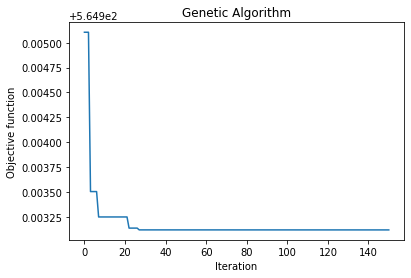

In [34]:
!pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga

# FUNCTION TO TRAIN WEIGHTS
def f(X):
    softmax_w = np.exp(X)/np.sum(np.exp(X))
    weighted_all_test_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_test_preds)])
    # print(weighted_all_test_preds.shape)
    # weighted_dev_preds = np.sum(weighted_all_test_preds, axis = 0)
    # final_dev_preds = np.mean(weighted_all_test_preds, axis = 0)
    score1 = mean_squared_error(y_test, weighted_all_test_preds[0], squared=False)
    score2 = mean_squared_error(y_test, weighted_all_test_preds[1], squared=False)
    score3 = mean_squared_error(y_test, weighted_all_test_preds[2], squared=False)
    return min(score1, score2,score3)

# TRAIN GA ENSEMBLE MODEL
varbound=np.array([[0, 1]]*all_test_preds.shape[0])
model=ga(function=f,dimension=all_test_preds.shape[0],variable_type='real',variable_boundaries=varbound)
model.run()

convergence=model.report
solution=model.output_dict
solution
X = solution['variable']
# MULTIPLYING MODEL PREDICTIONS WITH WEIGHTS  
softmax_w = np.exp(X)/np.sum(np.exp(X))
weighted_all_test_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_test_preds)])
final_dev_preds = np.mean(weighted_all_test_preds, axis = 0)
score = mean_squared_error(y_test, final_dev_preds, squared=False)

### Prospect for Future Feature Additions:

#### Country Tax Rates:

Based on the province of the POC and COVID-19 regulations, we can adjust our discount rates so as to meet up the loss in sales and customers caused due to hindrances in transportation and the increased tax rates.